In [1]:
import sympy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from expanders import *

### Ramanujan graph using the LPS explicit construct (special case of 3-regular graphs).

In [2]:
# Pick a prime number
p = sympy.prime(13)

builder = LPS3(p, remove_parallel_edges=False, remove_self_edges=False)
builder.build()
G = builder.G

### Graph

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


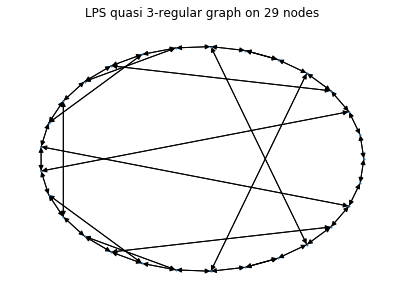

In [3]:
# save layout
pos = nx.shell_layout(G)

fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

nx.draw_networkx(G, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.set_title('LPS quasi 3-regular graph on {} nodes'.format(G.number_of_nodes()))
ax.axis('off')

plt.show()

### Eigenvalues vs Alon-Boppana bound

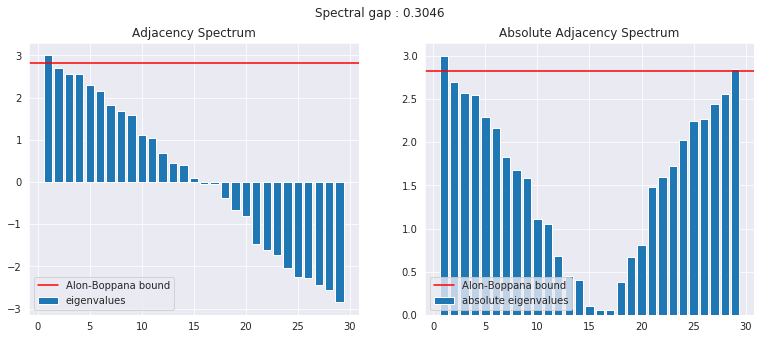

In [4]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(13, 5), nrows=1, ncols=2)

    fig.suptitle('Spectral gap : {:.4f}'.format(builder.spectral_gap))
    
    ax = axes[0]    
    ax.bar(range(1, p+1), builder.spectrum, label='eigenvalues')
    ax.axhline(y=builder.alon_boppana(3), color='r', label='Alon-Boppana bound')
    ax.set_title('Adjacency Spectrum')
    ax.legend(loc='lower left')

    ax = axes[1]
    ax.bar(range(1, p+1), np.abs(builder.spectrum), label='absolute eigenvalues')
    ax.axhline(y=builder.alon_boppana(3), color='r', label='Alon-Boppana bound')
    ax.set_title('Absolute Adjacency Spectrum')
    ax.legend(loc='lower left')

plt.show()

In [5]:
builder.is_ramanujan

(False, 'Alon-Boppana bound does not hold.')

### Misc

In [6]:
### Uncomment to check caching
# profile_cache()

### Uncomment to draw graphviz graph (works better on small graphs)
# graphviz_image(G)